In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
train_path = 'dataset/train'
test_path = 'dataset/test'
val_path = 'dataset/val'

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1/255) # Ölçeklendirme
test_data_gen = ImageDataGenerator(rescale=1/255)
val_data_gen = ImageDataGenerator(rescale=1/255)


In [ ]:
train_generator = train_data_gen.flow_from_directory(
        train_path,
        target_size=(224,224), # Görüntü boyutları
        batch_size=16,
        class_mode='categorical')  # Sınıf modu, çok sınıflı bir sınıflandırma olduğu için 'categorical'

In [ ]:
test_generator = test_data_gen.flow_from_directory(
    test_path,
    target_size=(224,224),  # Görüntü boyutları
    batch_size=16,
    class_mode='categorical'  # Sınıf modu, çok sınıflı bir sınıflandırma olduğu için 'categorical'
)

In [ ]:
val_generator = val_data_gen.flow_from_directory(
    val_path,
    target_size=(224,224),  # Görüntü boyutları
    batch_size=16,
    class_mode='categorical'  # Sınıf modu, çok sınıflı bir sınıflandırma olduğu için 'categorical'
)

In [ ]:
vgg = VGG16(
    input_shape=(224,224,3),
    weights='imagenet',
    include_top=False)

In [ ]:
model = Sequential()
model.add(vgg)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4 , activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='Adadelta', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(
    f'/content/drive/MyDrive/muhendislik-tasarimi/VGG/vgg-model_adadelta2.h5',
     monitor='val_accuracy',
     verbose=1,
     save_best_only=True,
     mode = 'max'
)

In [ ]:
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          verbose=1,
                          mode = 'max')

In [ ]:
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=15,
    callbacks = [earlystop, checkpoint])

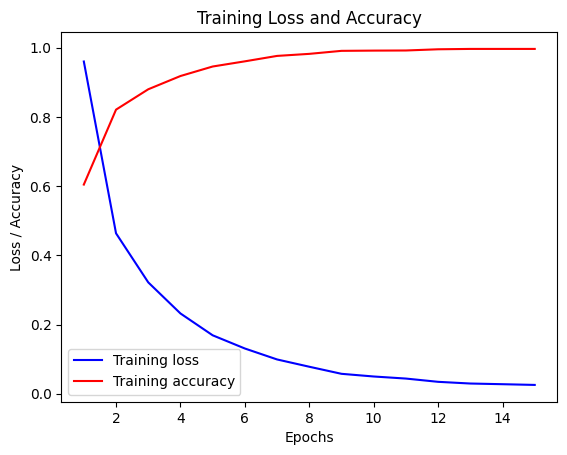

In [ ]:
train_loss = result.history['loss']
train_accuracy = result.history['accuracy']

# train loss ve train accuracy görselleştirilmesi
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()

plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



23/23 [==============================] - 29s 1s/step - loss: 0.1181 - accuracy: 0.9559
Test Loss: 0.11810389161109924
Test Accuracy: 0.9559228420257568


In [ ]:
# model ile tahmin etme
predictions = model.predict(test_generator)

# test verileri ve tahmin edilen değerler arasındaki karşılaştırma
num_samples_to_visualize = 20
test_labels = []  # Gerçek değerleri tutan boş liste
predicted_labels = []  # Tahmin edilen değerleri tutan boş liste

# test datalarından örnekler
for i, (_, labels) in enumerate(test_generator):
    test_labels.extend(labels.argmax(axis=1))  # Gerçek etiketleri al
    predicted_labels.extend(predictions.argmax(axis=1))  # Tahmin edilen etiketleri al
    if i == num_samples_to_visualize - 1:
        break

# Sonuçları görselleştir
plt.figure(figsize=(12, 8))
for i in range(num_samples_to_visualize):
    plt.subplot(5, 4, i + 1)
    plt.imshow(test_generator[i][0][0])  # Test resmini göster
    plt.title(f'Real: {test_labels[i]}, Predicted: {predicted_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()
